In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.8.0


In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

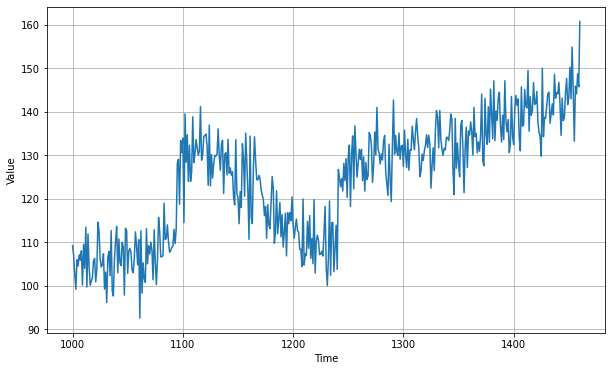

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [8]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)


Epoch 1/100
31/31 [==============================] - 1s 5ms/step - loss: 1783.1215
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 111.6223
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 57.9366
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 54.3700
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 54.2211
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 54.0617
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 54.4515
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 53.7397
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 52.5842
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 52.3261
Epoch 11/100
31/31 [==============================] - 1s 9ms/step - loss: 51.4990
Epoch 12/100
31/31 [==============================] - 1s 8ms/step - loss: 51.1985
Epoch 13/100
31/31 [==

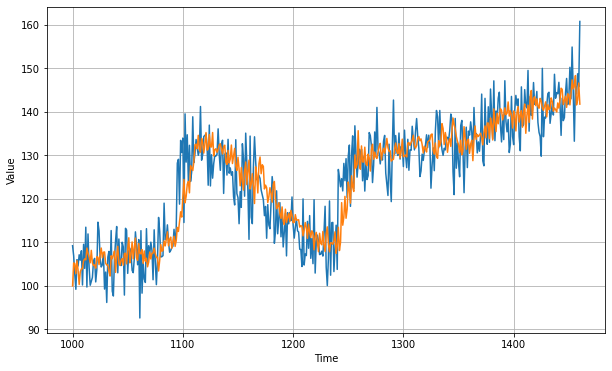

In [9]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7276435

In [11]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 5ms/step - loss: 616.4213 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 9ms/step - loss: 238.0054 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 7ms/step - loss: 106.3221 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 74.2994 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 67.1841 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 65.9458 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 65.7461 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 65.6323 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 65.5551 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 65.4093 - lr: 2.8184e-08
Epoch 11/100
31/

(1e-08, 0.001, 0.0, 300.0)

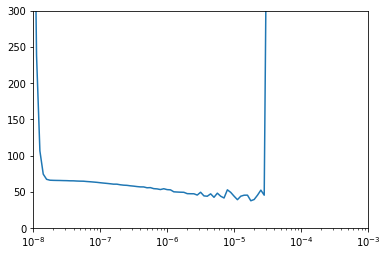

In [12]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [13]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
31/31 [==============================] - 1s 6ms/step - loss: 368.5528
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 53.1237
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 51.7453
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 50.2512
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 48.6896
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 49.0487
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 50.2759
Epoch 8/500
31/31 [==============================] - 0s 4ms/step - loss: 54.1831
Epoch 9/500
31/31 [==============================] - 0s 5ms/step - loss: 45.3794
Epoch 10/500
31/31 [==============================] - 0s 5ms/step - loss: 46.6892
Epoch 11/500
31/31 [==============================] - 0s 5ms/step - loss: 47.0895
Epoch 12/500
31/31 [==============================] - 0s 5ms/step - loss: 41.0980
Epoch 13/500
31/31 [====

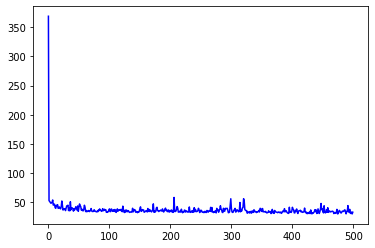

In [14]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[47.08945083618164, 41.09799575805664, 39.98186111450195, 45.05182647705078, 43.93095016479492, 46.131622314453125, 39.79586410522461, 40.698890686035156, 42.3565559387207, 40.039493560791016, 38.94129180908203, 42.78221893310547, 52.42979049682617, 44.28821563720703, 36.94894027709961, 38.527244567871094, 38.52857208251953, 39.43688201904297, 35.999610900878906, 39.81792449951172, 44.07296371459961, 43.76152420043945, 45.29823684692383, 36.063228607177734, 40.21269226074219, 35.57638931274414, 51.16987609863281, 37.510108947753906, 40.207489013671875, 40.70609664916992, 39.56693649291992, 35.04610824584961, 39.18101501464844, 37.15598678588867, 39.778812408447266, 42.730464935302734, 39.782527923583984, 36.76408767700195, 44.005340576171875, 34.751075744628906, 40.993770599365234, 47.37358474731445, 44.5455436706543, 42.79355239868164, 36.75945281982422, 38.45262908935547, 35.99291229248047, 35.580535888671875, 38.05581283569336, 45.17265701293945, 42.067779541015625, 34.3972396850585

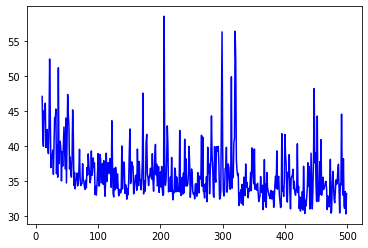

In [15]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

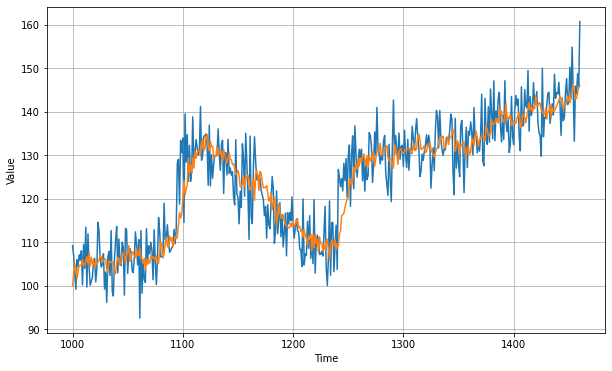

In [16]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.551642